In [1]:
import importlib
import utils  # or the name of your module
importlib.reload(utils)
from deeptime.clustering import KMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [34]:
deeptime.__version__

'0.4.5'

In [2]:
protein = 'chignolin'

coords = xyz_to_numpy(f'{protein}.xyz')
dists = get_inter_bead_distances(coords)
#data = coor.source(coords).get_output()    # Write the coordinates in the pyemma format
#traj = np.squeeze(np.array(data))
traj = dists
traj.shape

(100000, 45)

# Choosing lag time for tICA
...

0


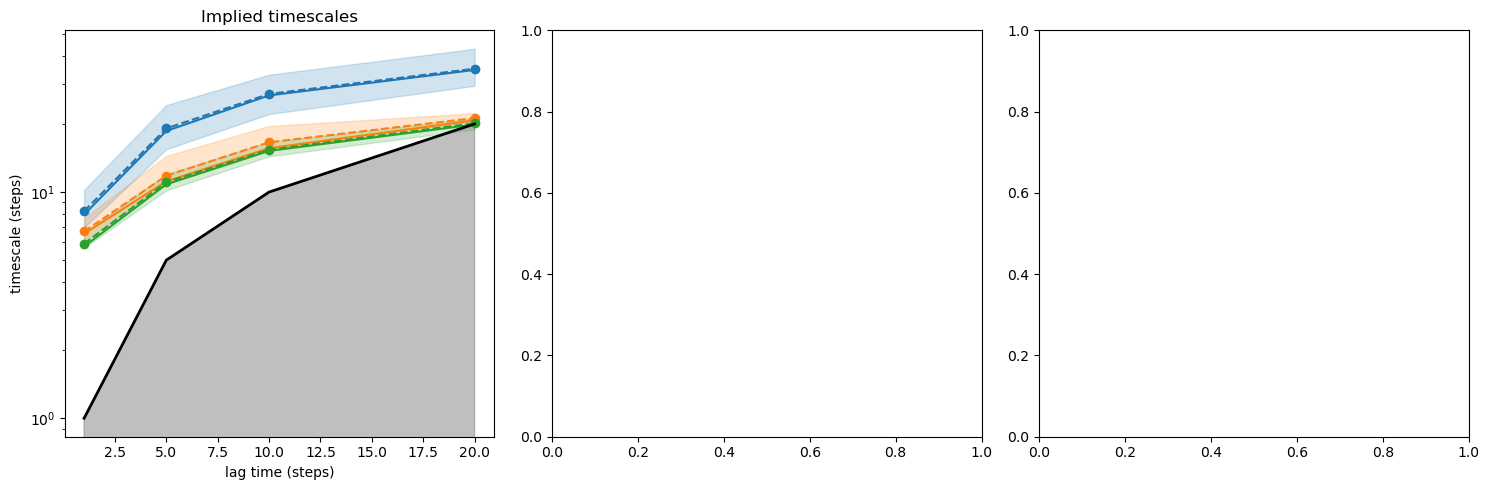

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, n_clusters in enumerate([150]):
    clustering = KMeans(n_clusters=n_clusters).fit_fetch(traj)
    dtraj = clustering.transform(traj)

    models = []
    lagtimes = [1, 5, 10, 20]
    for lagtime in lagtimes:
        counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtraj)
        models.append(BayesianMSM(n_samples=n_clusters).fit_fetch(counts))

    its_data = implied_timescales(models)

    plot_implied_timescales(its_data, n_its=3, ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_title('Implied timescales')
    ax[i].set_xlabel('lag time (steps)')
    ax[i].set_ylabel('timescale (steps)')
    print(i)

fig.tight_layout()

In [3]:
from deeptime.decomposition import TICA
importlib.reload(deeptime.plots)
from deeptime.plots import plot_density

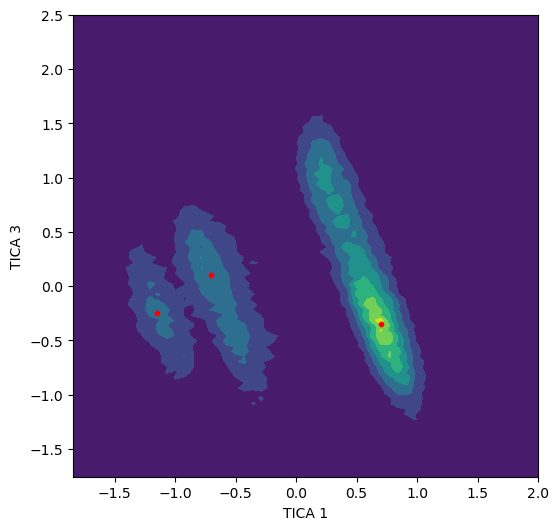

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
estimator = TICA(lagtime=10, dim=3).fit(traj)
model = estimator.fetch_model()
tica_traj = model.transform(traj)
plot_density(tica_traj[:,0], tica_traj[:,2], n_bins=100)
plt.plot([0.7], [-0.35], 'r.')
plt.plot([-0.7], [0.1], 'r.')
plt.plot([-1.15], [-0.25], 'r.')
plt.xlabel('TICA 1')
plt.ylabel('TICA 3')
ax.set_xlim(None, 2)
ax.set_ylim(None, 2.5)
#plt.savefig('tica_chignolin.png', dpi=300)

In [21]:
# Find representatives of the conformotions
def find_representative(tica_traj, minima):
    distances = np.linalg.norm(tica_traj - minima, axis=1)
    print(distances.shape)
    return np.argmin(distances)

minima1 = np.array([0.7, -0.35])
minima2 = np.array([-0.7, 0.1])
minima3 = np.array([-1.15, -0.25])

repr1 = find_representative(tica_traj[:,[0,2]], minima1)
repr2 = find_representative(tica_traj[:,[0,2]], minima2)
repr3 = find_representative(tica_traj[:,[0,2]], minima3)
repr1, repr2, repr3

(100000,)
(100000,)
(100000,)


(57048, 49541, 44879)

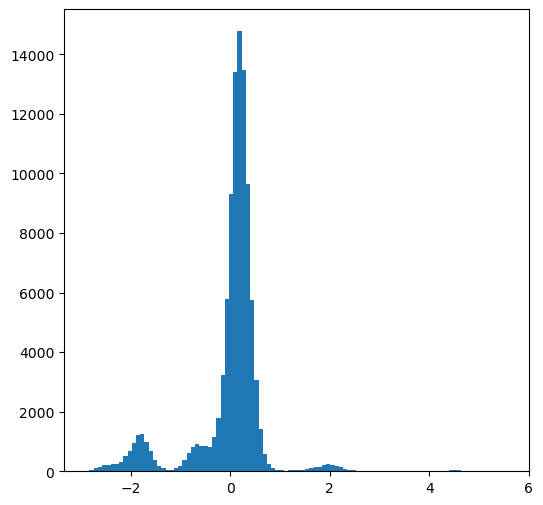

In [7]:
tica1 = tica_traj[:, 0]
tica2 = tica_traj[:, 1]
tica3 = tica_traj[:, 2]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax = plt.hist2d(tica2, tica1, bins=100, density=True, cmap='Blues')
ax = plt.hist(tica2, bins=100)

In [79]:
protein = 'trp_cage'
coords = xyz_to_numpy(f'{protein}.xyz')
helicity, helix_mask = get_per_residue_helicity(coords)
helicity

array([0.82416211, 0.95345469, 0.97791102, 0.98033063, 0.97641352,
       0.97257313, 0.91347109, 0.89332563, 0.02361759, 0.31289309,
       0.84562414, 0.71020594, 0.28258734, 0.01524148, 0.07558411,
       0.2223816 , 0.09702611])